In [1]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3 MB 22 kB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 3.8 MB 54.9 MB/s 
     |████████████████████████████████| 503 kB 82.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a8f1b347f5463151ab61a166cb09b5393cece014e2d802dae832d8316e5a8aab
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [2]:
!pip install keras==1.2.2

     |████████████████████████████████| 175 kB 4.3 MB/s 
     |████████████████████████████████| 2.8 MB 24.6 MB/s 
  Created wheel for keras: filename=Keras-1.2.2-py3-none-any.whl size=209601 sha256=fdb669ec957307ff21179fbecd7b522b0f7dcb593e196f4dd6391c049158d510
  Stored in directory: /root/.cache/pip/wheels/d1/32/23/2a1db3765ec19c91503843380a4f92b6530598949c661c5fa2
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=55601ecff3bd9532eaae239977a5576bd6908ce38f4330204111dc0a32ea0e14
  Stored in directory: /root/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built keras theano
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GoogleNews-vectors-negative300.bin.gz to GoogleNews-vectors-negative300.bin.gz


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from __future__ import division, print_function
from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Merge, Dropout, Reshape, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
from keras.preprocessing.sequence import pad_sequences
from ast import literal_eval
import gensim
from sklearn.utils import class_weight
import nltk

Using TensorFlow backend.


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
df = pd.read_csv("/content/drive/MyDrive/NLP_Final_Project/Train_qaOnly.csv",converters={"Answer": literal_eval})
df_val = pd.read_csv("/content/drive/MyDrive/NLP_Final_Project/Val_qaOnly.csv",converters={"Answer": literal_eval})
df_test = pd.read_csv("/content/drive/MyDrive/NLP_Final_Project/Test_qaOnly.csv",converters={"Answer": literal_eval})

df.head()

,Question,Answer,Answer Key,Fact
0,The sun is responsible for,"[puppies learning new tricks, children growing...",D,NaN
1,When standing miles away from Mount Rushmore,"[the mountains seem very close, the mountains ...",D,NaN
2,When food is reduced in the stomach,"[the mind needs time to digest, take a second ...",C,NaN
3,Stars are,"[warm lights that float, made out of nitrate, ...",C,NaN
4,You can make a telescope with a,"[straw, Glass, Candle, mailing tube]",D,NaN


In [7]:
df.drop(columns=['Fact'], inplace=True)

In [9]:
df_val.drop(columns=['Fact'], inplace=True)
df_test.drop(columns=['Fact'], inplace=True)

In [8]:
df[['A','B','C','D']] = pd.DataFrame(df.Answer.tolist(), index= df.index)
df.head()

,Question,Answer,Answer Key,A,B,C,D
0,The sun is responsible for,"[puppies learning new tricks, children growing...",D,puppies learning new tricks,children growing up and getting old,flowers wilting in a vase,"plants sprouting, blooming and wilting"
1,When standing miles away from Mount Rushmore,"[the mountains seem very close, the mountains ...",D,the mountains seem very close,the mountains are boring,the mountains look the same as from up close,the mountains seem smaller than in photographs
2,When food is reduced in the stomach,"[the mind needs time to digest, take a second ...",C,the mind needs time to digest,take a second to digest what I said,nutrients are being deconstructed,reader's digest is a body of works
3,Stars are,"[warm lights that float, made out of nitrate, ...",C,warm lights that float,made out of nitrate,great balls of gas burning billions of miles away,lights in the sky
4,You can make a telescope with a,"[straw, Glass, Candle, mailing tube]",D,straw,Glass,Candle,mailing tube


In [11]:
df_val[['A','B','C','D']] = pd.DataFrame(df_val.Answer.tolist(), index= df_val.index)
df_val.head()

,Question,Answer,Answer Key,A,B,C,D
0,Frilled sharks and angler fish live far beneat...,"[Deep sea animals, fish, Long Sea Fish, Far Se...",A,Deep sea animals,fish,Long Sea Fish,Far Sea Animals
1,"Gas can fill any container it is given, and li...","[is standard weight and size, is the opposite ...",D,is standard weight and size,is the opposite of variable,only needs a few,uses what it needs
2,"When birds migrate south for the winter, they ...","[they are genetically called to, their childre...",A,they are genetically called to,their children ask for them to,it is important to their happiness,they decide to each year
3,If a person walks in the opposite direction of...,"[west, north, east, south]",D,west,north,east,south
4,An example of lots kinetic energy would be,"[Drinking a cold glass of water, A snail movin...",D,Drinking a cold glass of water,A snail moving across the sidewalk,sitting without moving anywhere,An aircraft taking a trip


In [12]:
DATA_DIR = "/content"
MODEL_DIR = "/content"
WORD2VEC_BIN = "GoogleNews-vectors-negative300.bin.gz"
WORD2VEC_EMBED_SIZE = 300

QA_TRAIN_FILE = "train.tsv"

QA_EMBED_SIZE = 64
BATCH_SIZE = 32
NBR_EPOCHS = 20

In [13]:
WORD2VEC_BIN_DIR = "/content/drive/MyDrive/NLP_Final_Project"

In [14]:
qapairs = []
question_file = os.path.join(DATA_DIR, QA_TRAIN_FILE)
question_file

'/content/train.tsv'

In [15]:
print("Loading and formatting data...")
qfapairs = []
for i in range(len(df)):
  question = df['Question'][i]
  qwords = nltk.word_tokenize(question)
  correct_ans = df['Answer Key'][i]
  answers = df['A'][i]+'@'+df['B'][i]+'@'+df['C'][i]+'@'+df['D'][i]
  # training file parsing
  correct_ans_idx = ord(correct_ans) - ord('A')
  for idx, answer in enumerate(answers.split('@')):
    awords = nltk.word_tokenize(answer)
    qfapairs.append((qwords, awords, idx == correct_ans_idx))

Loading and formatting data...


In [16]:
qfapairs[0:5]

[(['The', 'sun', 'is', 'responsible', 'for'],
  ['puppies', 'learning', 'new', 'tricks'],
  False),
 (['The', 'sun', 'is', 'responsible', 'for'],
  ['children', 'growing', 'up', 'and', 'getting', 'old'],
  False),
 (['The', 'sun', 'is', 'responsible', 'for'],
  ['flowers', 'wilting', 'in', 'a', 'vase'],
  False),
 (['The', 'sun', 'is', 'responsible', 'for'],
  ['plants', 'sprouting', ',', 'blooming', 'and', 'wilting'],
  True),
 (['When', 'standing', 'miles', 'away', 'from', 'Mount', 'Rushmore'],
  ['the', 'mountains', 'seem', 'very', 'close'],
  False)]

In [17]:
len(qfapairs)

19828

In [18]:
qfapairs_val = []
for j in range(len(df_val)):
  question = df_val['Question'][j]
  qwords = nltk.word_tokenize(question)
  correct_ans = df_val['Answer Key'][j]
  answers = df_val['A'][j]+'@'+df_val['B'][j]+'@'+df_val['C'][j]+'@'+df_val['D'][j]
  # training file parsing
  correct_ans_idx = ord(correct_ans) - ord('A')
  for idx, answer in enumerate(answers.split('@')):
    awords = nltk.word_tokenize(answer)
    qfapairs_val.append((qwords, awords, idx == correct_ans_idx))

In [19]:
qfapairs_val[0:5]

[(['Frilled',
   'sharks',
   'and',
   'angler',
   'fish',
   'live',
   'far',
   'beneath',
   'the',
   'surface',
   'of',
   'the',
   'ocean',
   ',',
   'which',
   'is',
   'why',
   'they',
   'are',
   'known',
   'as'],
  ['Deep', 'sea', 'animals'],
  True),
 (['Frilled',
   'sharks',
   'and',
   'angler',
   'fish',
   'live',
   'far',
   'beneath',
   'the',
   'surface',
   'of',
   'the',
   'ocean',
   ',',
   'which',
   'is',
   'why',
   'they',
   'are',
   'known',
   'as'],
  ['fish'],
  False),
 (['Frilled',
   'sharks',
   'and',
   'angler',
   'fish',
   'live',
   'far',
   'beneath',
   'the',
   'surface',
   'of',
   'the',
   'ocean',
   ',',
   'which',
   'is',
   'why',
   'they',
   'are',
   'known',
   'as'],
  ['Long', 'Sea', 'Fish'],
  False),
 (['Frilled',
   'sharks',
   'and',
   'angler',
   'fish',
   'live',
   'far',
   'beneath',
   'the',
   'surface',
   'of',
   'the',
   'ocean',
   ',',
   'which',
   'is',
   'why',
   'they',
  

In [20]:
len(qfapairs_val)

2000

In [21]:
question_maxlen = max([len(qapair[0]) for qapair in qfapairs])
answer_maxlen = max([len(qapair[1]) for qapair in qfapairs])
seq_maxlen = max([question_maxlen, answer_maxlen])
print(question_maxlen, answer_maxlen, seq_maxlen)

76 23 76


In [22]:
question_maxlen_val = max([len(qapair[0]) for qapair in qfapairs_val])
answer_maxlen_val = max([len(qapair[1]) for qapair in qfapairs_val])
seq_maxlen_val = max([question_maxlen_val, answer_maxlen_val])
print(question_maxlen_val, answer_maxlen_val, seq_maxlen_val)

62 20 62


In [23]:
def build_vocab(stories, qapairs, testqs):
    wordcounts = collections.Counter()
    for story in stories:
        for sword in story:
            wordcounts[sword] += 1
    for qapair in qapairs:
        for qword in qapair[0]:
            wordcounts[qword] += 1
        for aword in qapair[1]:
            wordcounts[aword] += 1
    for testq in testqs:
        for qword in testq[0]:
            wordcounts[qword] += 1
        for aword in testq[1]:
            wordcounts[aword] += 1
    words = [wordcount[0] for wordcount in wordcounts.most_common()]
    word2idx = {w: i+1 for i, w in enumerate(words)}  # 0 = mask
    return word2idx

In [24]:
word2idx = build_vocab([], qfapairs, [])
vocab_size = len(word2idx) + 1 # include mask character 0

In [25]:
word2idx_val = build_vocab([], qfapairs_val, [])

In [26]:
qfapairs[0:2]

[(['The', 'sun', 'is', 'responsible', 'for'],
  ['puppies', 'learning', 'new', 'tricks'],
  False),
 (['The', 'sun', 'is', 'responsible', 'for'],
  ['children', 'growing', 'up', 'and', 'getting', 'old'],
  False)]

In [27]:
def vectorize_qapairs(qfapairs, word2idx, seq_maxlen):
    Xq, Xf, Xa, Y = [], [], [], []
    for qapair in qfapairs:
        Xq.append([word2idx[qword] for qword in qapair[0]])
        Xa.append([word2idx[aword] for aword in qapair[1]])
        Y.append(np.array([1, 0]) if qapair[2] else np.array([0, 1]))
    return (pad_sequences(Xq, maxlen=seq_maxlen), 
            pad_sequences(Xa, maxlen=seq_maxlen),
            np.array(Y))

In [28]:
word2idx['puppies']

3991

In [29]:
Xqtrain, Xatrain, Ytrain = vectorize_qapairs(qfapairs, word2idx, seq_maxlen)
Xqval, Xaval, Yval = vectorize_qapairs(qfapairs_val, word2idx_val, seq_maxlen)
print(Xqtrain.shape, Xqval.shape, Xatrain.shape, Xaval.shape, 
      Ytrain.shape, Yval.shape)

(19828, 76) (2000, 76) (19828, 76) (2000, 76) (19828, 2) (2000, 2)


In [ ]:
Ytrain[5000:5003]

array([[1, 0],
       [0, 1],
       [0, 1]])

In [ ]:
np.unique(Ytrain)

array([0, 1])

In [30]:
Ytrain_flat = np.argmax(Ytrain, axis=1)
Ytrain_flat.shape

(19828,)

In [31]:
Ytrain_flat[5000:5003]

array([0, 1, 1])

In [32]:
qa_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Ytrain_flat), y=Ytrain_flat)
qa_class_weights

array([2.        , 0.66666667])

In [33]:
qa_class_weights_dict = dict(zip(np.unique(Ytrain_flat), qa_class_weights))
qa_class_weights_dict

{0: 2.0, 1: 0.6666666666666666}

In [34]:
from sklearn import preprocessing

In [35]:
scaler_q = preprocessing.StandardScaler().fit(Xqtrain)
Xqtrain_scaled = scaler_q.transform(Xqtrain)
Xqval_scaled = scaler_q.transform(Xqval)

In [36]:
scaler_a = preprocessing.StandardScaler().fit(Xatrain)
Xatrain_scaled = scaler_a.transform(Xatrain)
Xaval_scaled = scaler_a.transform(Xaval)

In [37]:
Xaval_scaled[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00710185, -0.00710185,
       -0.01529568, -0.00712752, -0.01513855, -0.01408964, -0.0112724 ,
       -0.01635382, -0.01282065, -0.01597278, -0.02659753, -0.03056932,
       -0.04035629, -0.05115299, -0.07355511, -0.07915404, -0.11

In [38]:
print("Loading Word2Vec model and generating embedding matrix...")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join(WORD2VEC_BIN_DIR, WORD2VEC_BIN), binary=True)
embedding_weights = np.zeros((vocab_size, WORD2VEC_EMBED_SIZE))
for word, index in word2idx.items():
    try:
        embedding_weights[index, :] = word2vec[word.lower()]
    except KeyError:
        pass

Loading Word2Vec model and generating embedding matrix...


In [39]:
QA_EMBED_SIZE = 16
NBR_EPOCHS = 40

In [41]:
print("Building model...")
qenc = Sequential()
qenc.add(Embedding(output_dim=WORD2VEC_EMBED_SIZE, input_dim=vocab_size,
                   input_length=seq_maxlen, weights=[embedding_weights]))
qenc.add(LSTM(QA_EMBED_SIZE, return_sequences=True))
qenc.add(Dropout(0.4))

aenc = Sequential()
aenc.add(Embedding(output_dim=WORD2VEC_EMBED_SIZE, input_dim=vocab_size,
                   input_length=seq_maxlen,
                   weights=[embedding_weights]))
aenc.add(LSTM(QA_EMBED_SIZE, return_sequences=True))
aenc.add(Dropout(0.4))

# attention model
attn = Sequential()
attn.add(Merge([qenc, aenc], mode="dot", dot_axes=[1, 1]))
attn.add(Flatten())
attn.add(Dense((seq_maxlen * QA_EMBED_SIZE)))
attn.add(Reshape((seq_maxlen, QA_EMBED_SIZE)))

model = Sequential()
model.add(Merge([qenc, attn], mode="sum"))
model.add(Flatten())
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

Building model...


In [42]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_4 (Embedding)          (None, 76, 300)       3405300                                      
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 76, 16)        20288                                        
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 76, 16)        0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 76, 300)       3405300                                      
___________________________________________________________________________________________

In [43]:
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "qa-lstm-attn-best-qaWithFact.hdf5"),
    verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=8)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-8)
qa_callbacks = [model_checkpoint, early_stopping_callback, reduce_lr_callback]

In [44]:
print("Training...")
model_history = model.fit([Xqtrain_scaled, Xatrain_scaled], Ytrain, batch_size=BATCH_SIZE,
          nb_epoch=NBR_EPOCHS, validation_data=([Xqval_scaled, Xaval_scaled], Yval),
          callbacks=qa_callbacks, class_weight=qa_class_weights_dict)

Training...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 19828 samples, validate on 2000 samples
Epoch 1/40
19828/19828 [==============================] - 93s - loss: 0.6953 - acc: 0.4869 - val_loss: 0.7000 - val_acc: 0.2495
Epoch 2/40
19828/19828 [==============================] - 91s - loss: 0.6928 - acc: 0.5373 - val_loss: 0.6888 - val_acc: 0.6540
Epoch 3/40
19828/19828 [==============================] - 90s - loss: 0.6895 - acc: 0.5705 - val_loss: 0.6738 - val_acc: 0.6560
Epoch 4/40
19828/19828 [==============================] - 90s - loss: 0.6866 - acc: 0.6123 - val_loss: 0.7046 - val_acc: 0.2530
Epoch 5/40
19828/19828 [==============================] - 90s - loss: 0.6853 - acc: 0.6143 - val_loss: 0.6918 - val_acc: 0.6525
Epoch 6/40
19828/19828 [==============================] - 90s - loss: 0.6857 - acc: 0.6143 - val_loss: 0.6974 - val_acc: 0.6525
Epoch 7/40
19828/19828 [==============================] - 90s - loss: 0.684

In [ ]:
from google.colab import files
files.download('/content/qa-lstm-attn-best-qaWithFact.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [46]:
def create_line_charts(df, metric_name, title, xlabel, ylabel, figsize=(12,8)):
  fig, ax = plt.subplots(figsize=figsize)
  plt.plot('epochs', 'train_' + metric_name, data=df)
  plt.plot('epochs', 'val_' + metric_name, data=df)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend()
  plt.show()

def create_metrics_df(history_data, num_epochs, metric_name):
  epochs_val = list(range(1, num_epochs+1))
  training_metric_val = history_data.history[metric_name]
  validation_metric_val = history_data.history['val_' + metric_name]
  metric_dict = {
    'epochs':epochs_val,
    'train_' + metric_name: training_metric_val,
    'val_' + metric_name: validation_metric_val
  }
  metric_df = pd.DataFrame(metric_dict)
  return metric_df

In [47]:
def generate_metrics_plots(model_history_data, epochs):
  all_metrics = ['acc', 'loss']
  for cur_metric in all_metrics:
    create_line_charts(create_metrics_df(model_history_data, epochs, cur_metric), cur_metric, 'Comparison of training and validation {} values'.format(cur_metric), 'Epochs', '{} Values'.format(cur_metric))

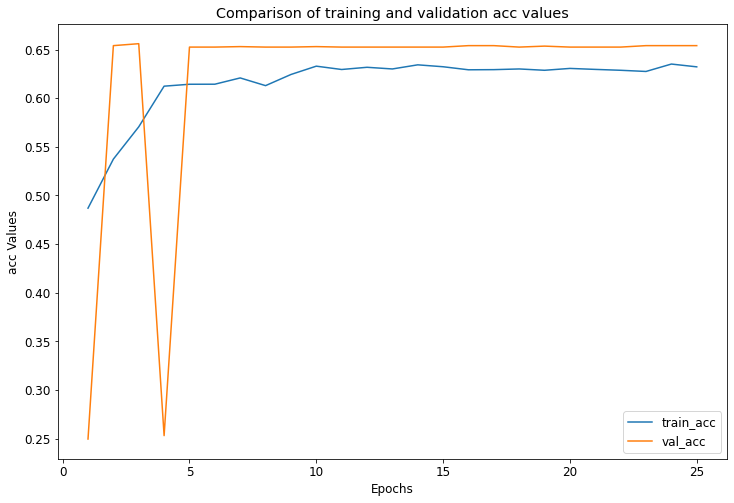

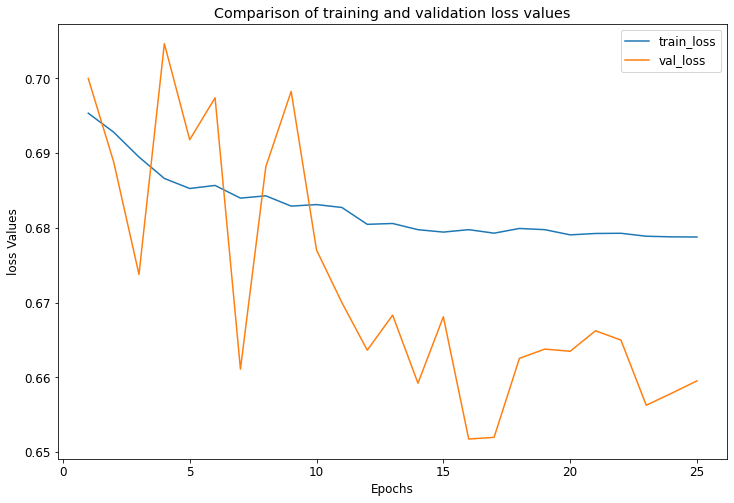

In [48]:
generate_metrics_plots(model_history, 25)

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [50]:
def generate_confusion_matrix(y_true, y_pred, class_labels, fig_size=(10,10), cmap='inferno'):
  cm = confusion_matrix(y_true, y_pred)
  cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  fig, ax = plt.subplots(figsize=fig_size)
  ax.grid(False)
  cmdisp.plot(ax=ax, cmap=cmap)
  plt.show()

In [51]:
df_test[['A','B','C','D']] = pd.DataFrame(df_test.Answer.tolist(), index= df_test.index)
df_test.head()

,Question,Answer,Answer Key,A,B,C,D
0,A person wants to start saving money so that t...,"[make more phone calls, quit eating lunch out,...",B,make more phone calls,quit eating lunch out,buy less with monopoly money,have lunch with friends
1,There is most likely going to be fog around:,"[a marsh, a tundra, the plains, a desert]",A,a marsh,a tundra,the plains,a desert
2,Predators eat,"[lions, humans, bunnies, grass]",C,lions,humans,bunnies,grass
3,Oak tree seeds are planted and a sidewalk is p...,"[roots may be split, roots may begin to die, p...",C,roots may be split,roots may begin to die,parts may break the concrete,roots may fall apart
4,An electric car runs on electricity via,"[gasoline, a power station, electrical conduct...",C,gasoline,a power station,electrical conductors,fuel


In [52]:
qapairs_test = []
for k in range(len(df_test)):
  question = df_test['Question'][k]
  qwords = nltk.word_tokenize(question)
  correct_ans = df_test['Answer Key'][k]
  answers = df_test['A'][k]+'@'+df_test['B'][k]+'@'+df_test['C'][k]+'@'+df_test['D'][k]
  # training file parsing
  correct_ans_idx = ord(correct_ans) - ord('A')
  for idx, answer in enumerate(answers.split('@')):
    awords = nltk.word_tokenize(answer)
    qapairs_test.append((qwords, awords, idx == correct_ans_idx))

In [53]:
word2idx_test = build_vocab([], qapairs_test, [])

In [54]:
Xqtest, Xatest, Ytest = vectorize_qapairs(qapairs_test, word2idx_test, seq_maxlen)

In [55]:
Xqtest_scaled = scaler_q.transform(Xqtest)
Xatest_scaled = scaler_a.transform(Xatest)

In [56]:
print("Evaluate on test data")
results = model.evaluate([Xqtest_scaled, Xatest_scaled], Ytest, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
2000/2000 [==============================] - 1s     
test loss, test acc: [0.661812388420105, 0.658]


In [57]:
predictions = model.predict([Xqtest_scaled, Xatest_scaled], verbose=0)

In [58]:
predictions[0:5]

array([[0.44310078, 0.55689925],
       [0.52663785, 0.47336218],
       [0.51571035, 0.48428962],
       [0.44310078, 0.55689925],
       [0.44115353, 0.5588465 ]], dtype=float32)

In [59]:
Ypred = np.argmax(predictions, axis=1)

In [60]:
Ytrue = np.argmax(Ytest, axis=1)

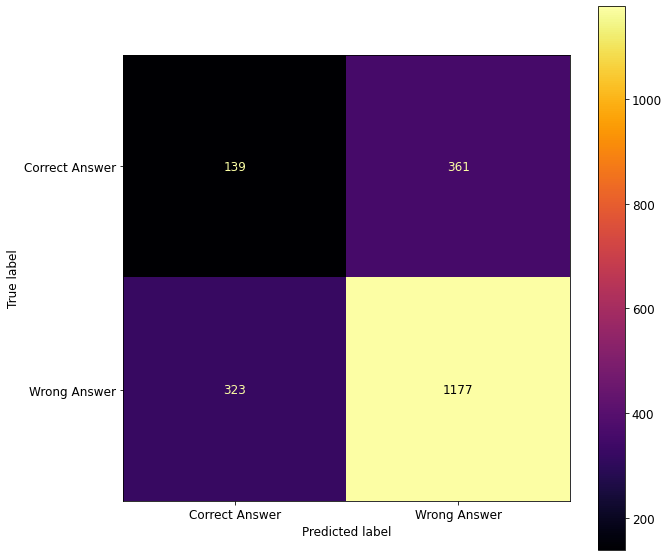

In [61]:
generate_confusion_matrix(Ytrue, Ypred, ['Correct Answer','Wrong Answer'])

In [62]:
def save_np_data(file_path, input_arr):
  with open(file_path, 'wb') as f:
    np.save(f, input_arr)

In [63]:
save_np_data(os.path.join('/content/drive/MyDrive/NLP_Final_Project', 'model_qa_predictions.npy'), predictions)
save_np_data(os.path.join('/content/drive/MyDrive/NLP_Final_Project', 'model_qa_test.npy'), Ytest)